Cargo las librerias necesarias

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import numpy as np

# Preprocesado
Cargo los datos y elimino la columna de especimenes ya que no se usara para la clasificación.

In [44]:
df = pd.read_csv('data/leaf.csv',sep=',',names=['Class','Specimen Number','Eccentricity','Aspect Ratio','Elongation','Solidity','Stochastic Convexity','Isoperimetric Factor','Maximal Indentation Depth','Lobedness','Average Intensity','Average Contrast','Smoothness','Third moment','Uniformity','Entropy'])
df = df.drop(['Specimen Number'],axis=1)

Observamos los 5 primeros elementos de la tabla

In [45]:
df.head(5)

,Class,Eccentricity,Aspect Ratio,Elongation,Solidity,Stochastic Convexity,Isoperimetric Factor,Maximal Indentation Depth,Lobedness,Average Intensity,Average Contrast,Smoothness,Third moment,Uniformity,Entropy
0,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.83592,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,0.74173,1.5257,0.36116,0.98152,0.99825,0.79867,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,0.76722,1.5725,0.38998,0.97755,1.00000,0.80812,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,0.73797,1.4597,0.35376,0.97566,1.00000,0.81697,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,0.82301,1.7707,0.44462,0.97698,1.00000,0.75493,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214


### Escalado de los Datos
Para escalar los datos escojo el StandarScaler de sklearn para que todas las variables pasen a tener media 0 y varianza del mismo orden

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop('Class',axis=1))
scaled_features = scaler.transform(df.drop('Class',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df.columns[1:])

Observo los histogramas de todas las variables

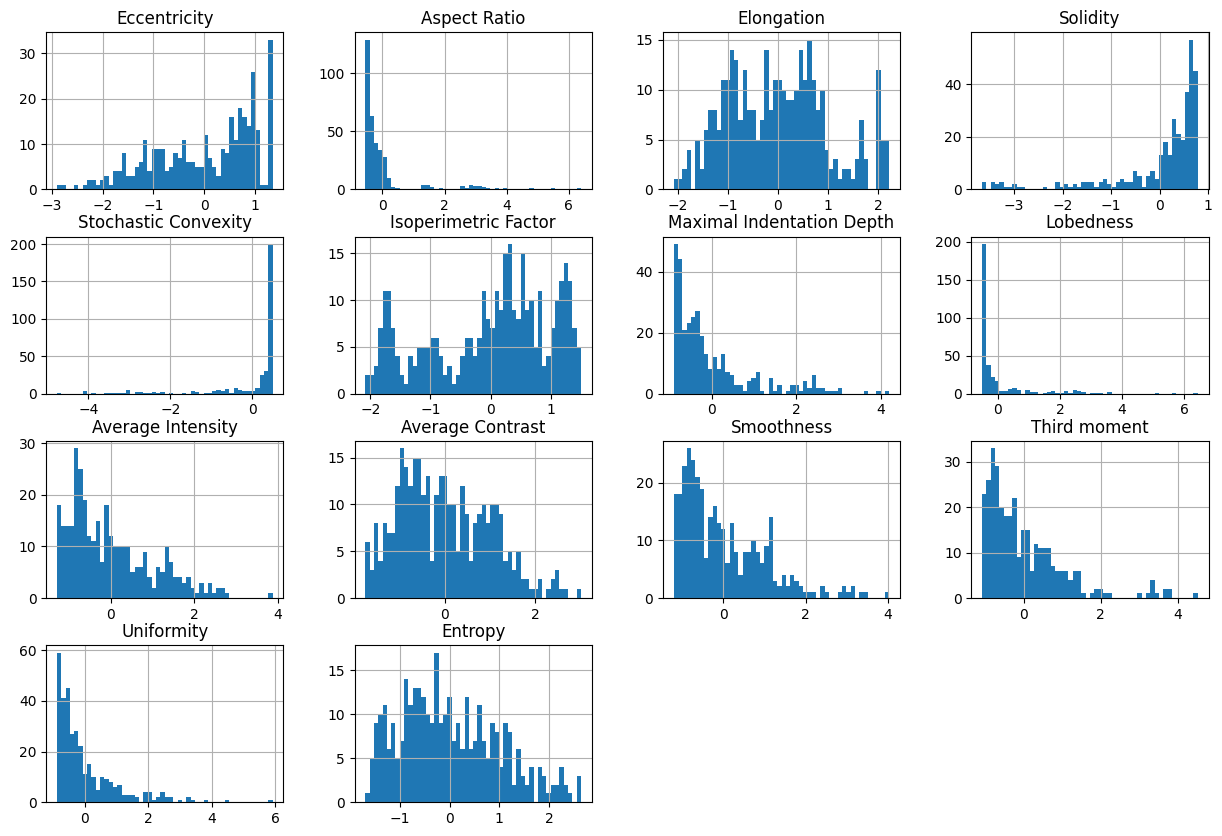

In [47]:
df_feat.head()
# show histogram of the scaled data
_ = df_feat.hist(bins=50, figsize=(15,10))

### Separo entre datos de test y de entrenamiento

In [48]:
train_X, test_X, train_y, test_y = train_test_split(df_feat, df['Class'], test_size=40,random_state=12)

# Entrenamiento de Modelos

### Regresión Logistica
Uso regressión logistica e imprimo los mejores parametros

In [49]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(solver='lbfgs', max_iter=10000)
param_grid = {'C': [0.1,1, 10,100, 1000]}
grid = GridSearchCV(logmodel,param_grid,refit=True,cv=5)
grid.fit(train_X,train_y)
print(grid.best_params_)
print(grid.best_estimator_)


{'C': 100}
LogisticRegression(C=100, max_iter=10000)


Muestros las puntuaciónes de la clasificacion sobre la particion de test

In [50]:
pred_y = grid.predict(test_X)
print(f"Accuracy: { accuracy_score(test_y, pred_y)*100:.2f}%")
print(f"Recall: { recall_score(test_y, pred_y, average='macro',zero_division=0)*100:.2f}%")
print(f"Precision: { precision_score(test_y, pred_y, average='macro',zero_division=0)*100:.2f}%")

Accuracy: 85.00%
Recall: 85.79%
Precision: 86.51%


Muestro la matriz de confusión.

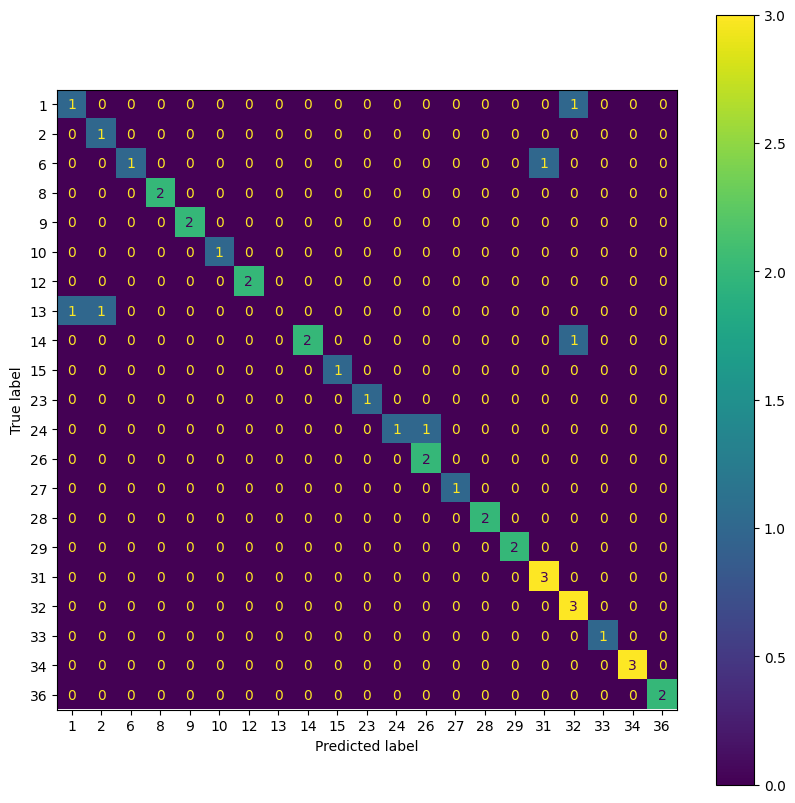

In [51]:
from sklearn.metrics import  ConfusionMatrixDisplay
from matplotlib import pyplot as plt

ax = plt.subplot()
ax.figure.set_size_inches(10,10)
disp = ConfusionMatrixDisplay.from_predictions(pred_y, test_y,ax=ax)



In [52]:
# Obtengo cual es la verdadera clase para el indice -3
grid.best_estimator_.classes_[-3]


34

<AxesSubplot:>

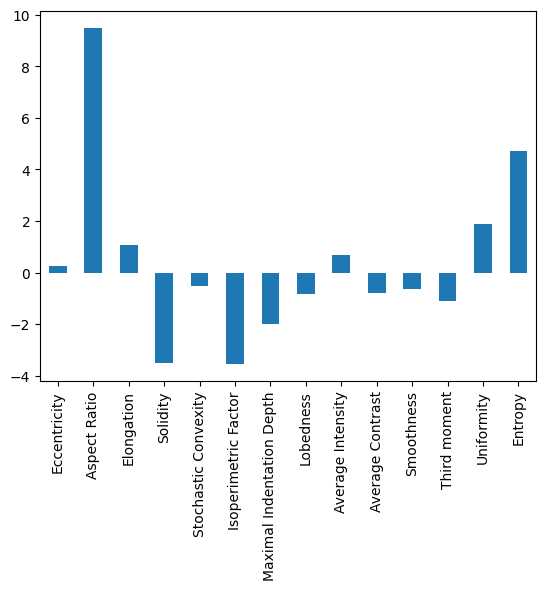

In [53]:
# Observos los pesos del mejor modelo para la clase 34 (el indice lo obtuve en la celda anterior)
weights = pd.Series(grid.best_estimator_.coef_[-3],index=df.columns[1:])
weights.plot(kind='bar')


<AxesSubplot:>

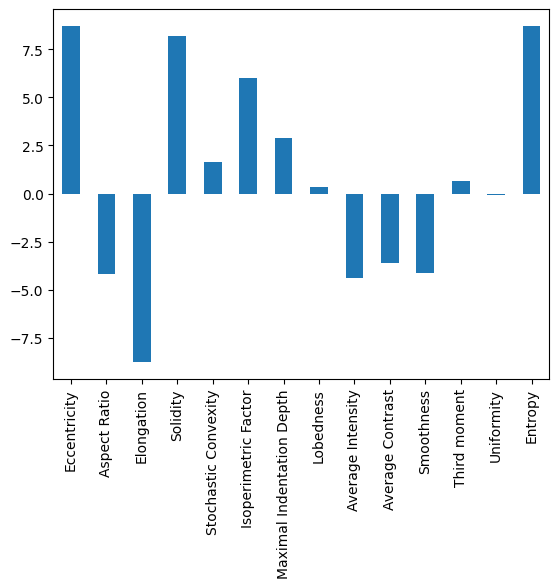

In [54]:
# Observos los pesos del mejor modelo para la clase 27
weights = pd.Series(grid.best_estimator_.coef_[20],index=df.columns[1:])
weights.plot(kind='bar')

### Árboles de decisión
Entreno el modelo y pruebo con distintos valores de 'max_depth', ' 'min_samples_leaf' y 'min_samples_split' y muestor los mejores

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': np.arange(3, 12), 'min_samples_leaf': [5,20, 40, 30], 'min_samples_split': [5,20, 30, 40]}
grid = GridSearchCV(DecisionTreeClassifier(),param_grid,refit=True,cv=5)
grid.fit(train_X,train_y)
print(grid.best_params_)
# Score
grid_predictions = grid.predict(test_X)
grid.score(test_X, test_y)


{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}


0.625

Muestro las métricas de la clasificación

In [56]:
print(f"Accuracy: { accuracy_score(test_y, grid_predictions)*100:.2f}%")
print(f"Recall: { recall_score(test_y, grid_predictions, average='macro',zero_division=0)*100:.2f}%")
print(f"Precision: { precision_score(test_y, grid_predictions, average='macro',zero_division=0)*100:.2f}%")

Accuracy: 62.50%
Recall: 55.14%
Precision: 65.97%


Muestro la matriz de confusión

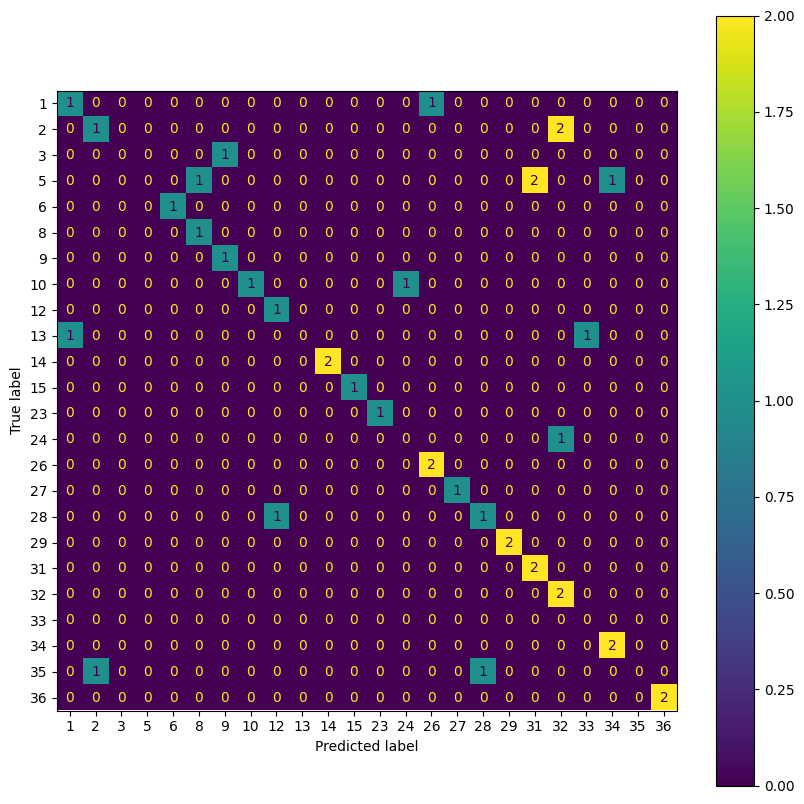

In [57]:
ax = plt.subplot()
ax.figure.set_size_inches(10,10)
disp = ConfusionMatrixDisplay.from_predictions(grid_predictions, test_y,ax=ax)



Muestro las predicciones de la clase que hace el árbol sobre las 40 instancias de test

In [58]:
grid_predictions


array([26, 14,  6, 15, 35,  9, 34,  8,  2, 32, 12, 31,  1, 28, 24,  3, 10,
       31,  5, 26, 14, 36, 29, 27,  5, 36,  2,  5, 29, 34,  2, 35,  1, 10,
        5, 13, 13, 28, 23, 32], dtype=int64)

Muestro las 4 primeras capas del árbol de decisión

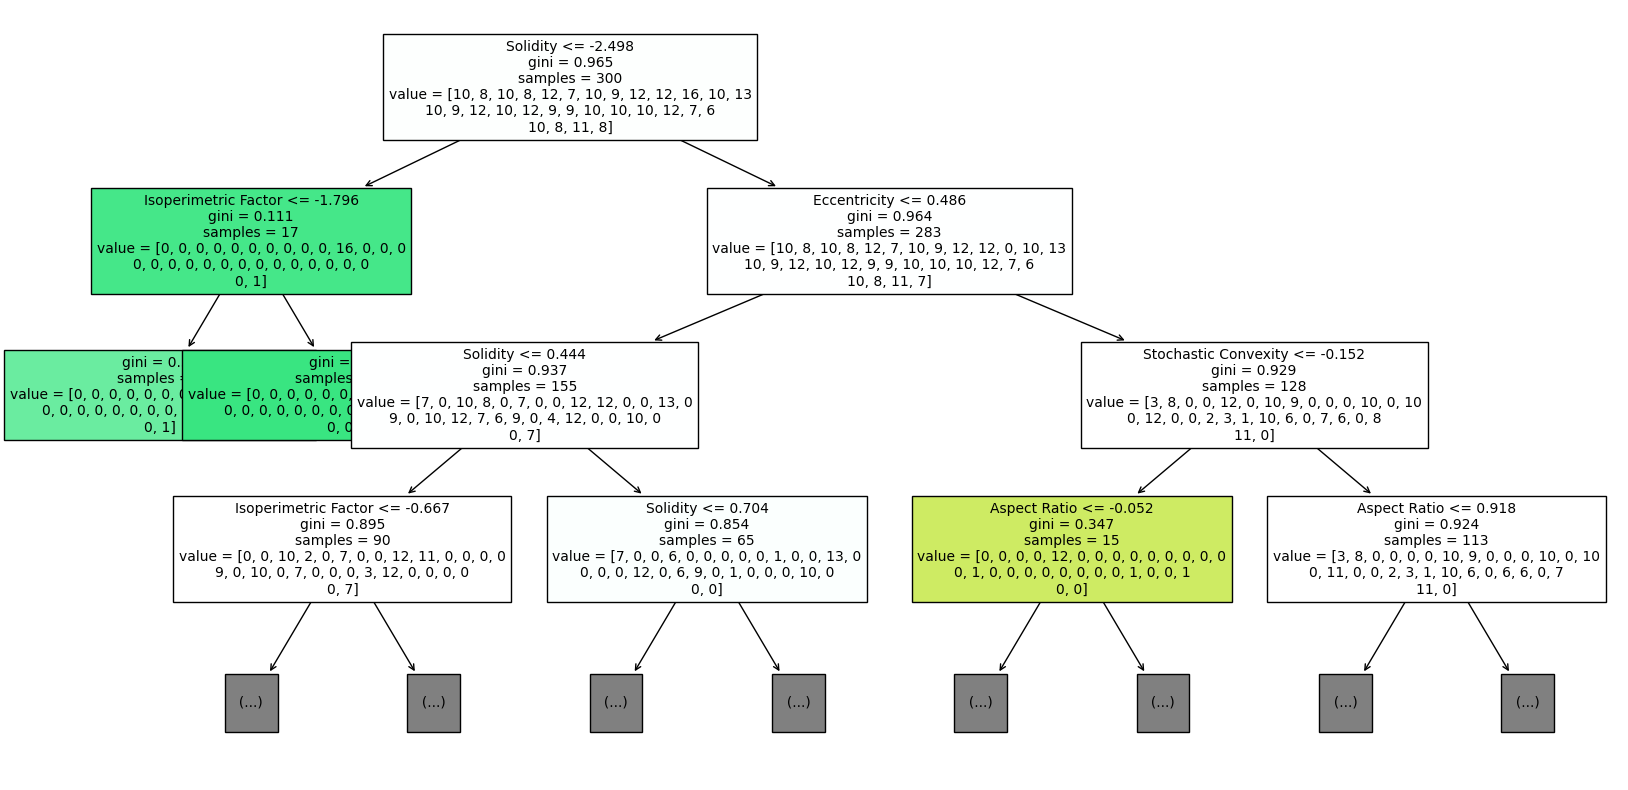

In [59]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
_ = plot_tree(grid.best_estimator_, feature_names=df.drop('Class',axis=1).columns, filled=True,max_depth=3, fontsize=10)


Obtengo y muestro los nodos por los que pasa una instancia para predecir su clase, uso el índice 22 como ejemplo para ver su camino, la instancia en la posición 22 de conjunto de test realmente pertenece a la clase 29.

In [60]:

node_indicator = grid.best_estimator_.decision_path(test_X)
node_index = node_indicator

# Muestro los indices de los nodos por los que pasa la instancia 22
sample_id = 22
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

node_index



array([ 0,  4, 52, 56, 57, 58, 59, 60], dtype=int32)

Muestro de manera más legible el camino que sigue el arbol para tomar la decision de que a que claes pertenece la instancia.

In [61]:
tr = grid.best_estimator_.tree_
for x,i in enumerate(node_index):
    if tr.feature[i] != -2:
        print(f"Node {i} {df_feat.columns[tr.feature[i]]} <= {tr.threshold[i]:.2f}  Result: {node_index[x+1] == tr.children_left[i]}")

Node 0 Solidity <= -2.50  Result: False
Node 4 Eccentricity <= 0.49  Result: False
Node 52 Stochastic Convexity <= -0.15  Result: False
Node 56 Aspect Ratio <= 0.92  Result: True
Node 57 Entropy <= 0.12  Result: True
Node 58 Solidity <= 0.61  Result: True
Node 59 Third moment <= -0.91  Result: True


### K Nearest Neighbours
Entreno el modelo probando con diferentes valores de k, muestro el mejor y muestro el score que consigue el modelo.

In [62]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': np.arange(1, 20)}
grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,cv=5)
grid.fit(train_X,train_y)
print(grid.best_params_)
# Score
grid_predictions = grid.predict(test_X)
grid.score(test_X, test_y)

{'n_neighbors': 1}


0.775

Muestro todas las metricas de clasificación

In [63]:
print(f"Accuracy: { accuracy_score(test_y, grid_predictions)*100:.2f}%")
print(f"Recall: { recall_score(test_y, grid_predictions, average='macro',zero_division=0)*100:.2f}%")
print(f"Precision: { precision_score(test_y, grid_predictions, average='macro',zero_division=0)*100:.2f}%")

Accuracy: 77.50%
Recall: 68.55%
Precision: 65.94%


Muestro la matriz de confusión.

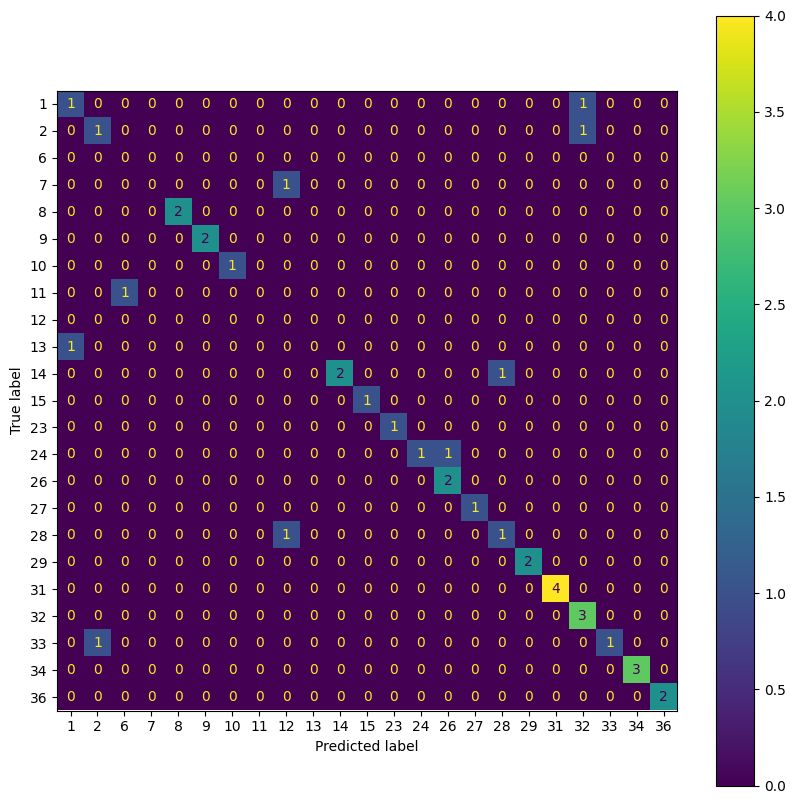

In [64]:
ax = plt.subplot()
ax.figure.set_size_inches(10,10)
disp = ConfusionMatrixDisplay.from_predictions(grid_predictions, test_y,ax=ax)


A continuacion, muestro varios gráficos en 2d y 3d para observar la disposición espacial de los datos y asi obtener alguna conclusión sobre el k escogido.

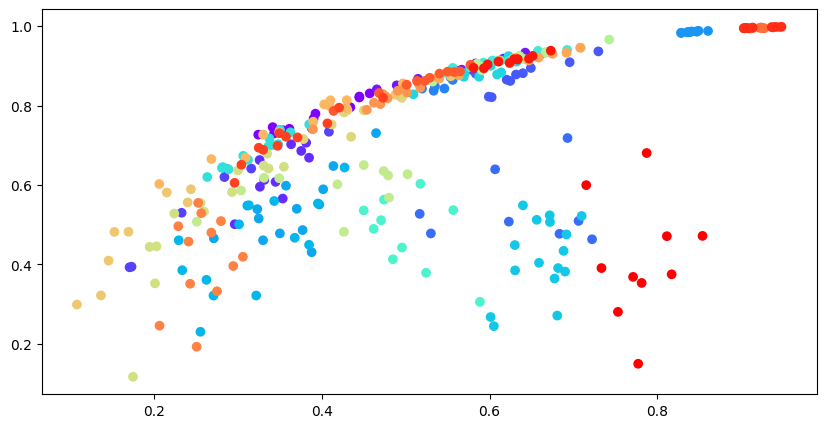

In [65]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.scatter(df['Elongation'],df['Eccentricity'],c=df['Class'],cmap='rainbow')

Text(0.5, 0, 'Aspect Ratio')

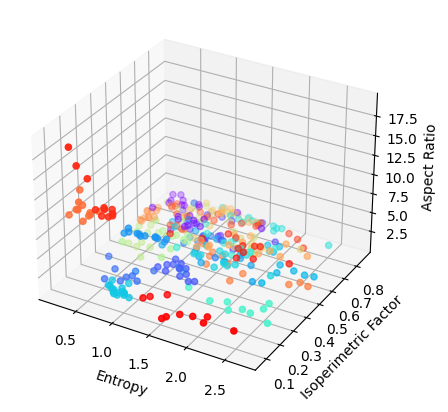

In [66]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Entropy'],df['Isoperimetric Factor'],df['Aspect Ratio'],c=df['Class'],cmap='rainbow')
ax.set_xlabel('Entropy')
ax.set_ylabel('Isoperimetric Factor')
ax.set_zlabel('Aspect Ratio')

Text(0.5, 0, 'pca3')

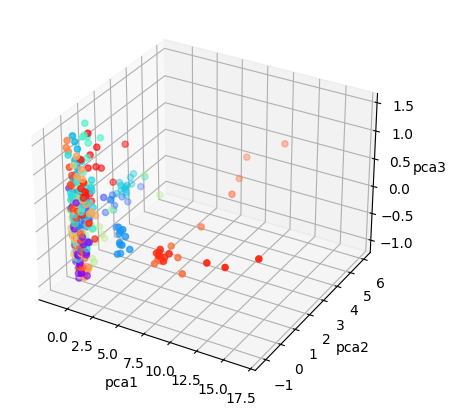

In [67]:
# Uso la técnica de reducción de dimensionalidad PCA para reducir todo el conjunto de datos a 3 variables.
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(df.drop('Class',axis=1))
pca_features = pca.transform(df.drop('Class',axis=1))
pca_features.shape
pca_df = pd.DataFrame(pca_features,columns=['pca1','pca2','pca3'])
pca_df.head()
pca_df['Class'] = df['Class']
pca_df.head()


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['pca1'],pca_df['pca2'],pca_df['pca3'],c=pca_df['Class'],cmap='rainbow')
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')



### Support Vector Machine
Entreno un modelo de SVC con diferentes valores para el parametro C y gamma, finalmente muestro la mejor combinación posible escogida por la función GridSearchCV

In [68]:
from sklearn.svm import SVC

param_grid = {'C': [1000,1500,2000,2500,3000], 'gamma': [0.01,0.008,0.005,0.002]}
grid = GridSearchCV(SVC(),param_grid,refit=True,cv=5)
grid.fit(train_X,train_y)
print(grid.best_params_)

# Score
grid_predictions = grid.predict(test_X)
grid.score(test_X, test_y)


{'C': 1000, 'gamma': 0.008}


0.85

Muestro las metricas de clasificación.

In [69]:
print(f"Accuracy: { accuracy_score(test_y, grid_predictions)*100:.2f}%")
print(f"Recall: { recall_score(test_y, grid_predictions, average='macro',zero_division=0)*100:.2f}%")
print(f"Precision: { precision_score(test_y, grid_predictions, average='macro',zero_division=0)*100:.2f}%")

Accuracy: 85.00%
Recall: 86.03%
Precision: 84.13%


La matriz de confusión

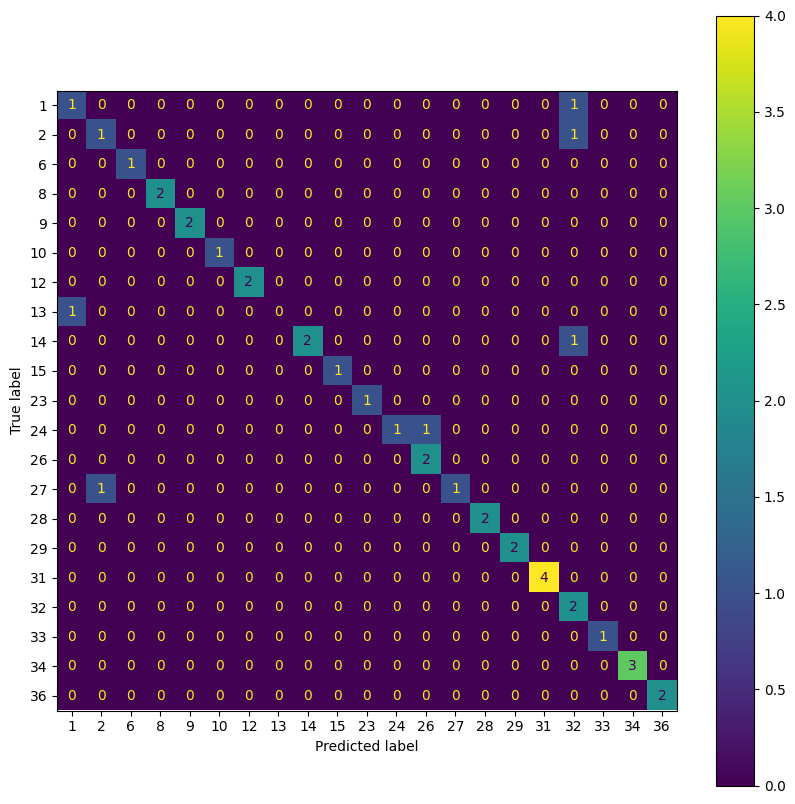

In [70]:
ax = plt.subplot()
ax.figure.set_size_inches(10,10)
disp = ConfusionMatrixDisplay.from_predictions(grid_predictions, test_y,ax=ax)  
